# Engineering Transparency into Your Multinomial Machine Learning Model with Python (Based on simulated data)

### Multinomial partial dependence, ICE, and Shapley explanations
In this notebook a gradient boosting machine (GBM) is trained to predict a multinomial target using a simulated dataset, Python, NumPy, Pandas, and XGBoost. First, the dataset is simulated. Then the multinomial model is trained. After the model is trained, partial dependence and individual conditional expectation (ICE) plots are used to analyze and verify the model's behavior. Finally an example of creating regulator mandated reason codes from high fidelity Shapley explanations for any model prediction is presented. This combination of partial dependence, ICE, and Shapley explanations is probably the most direct way to create an interpretable machine learning model today.

In addition to above, `eli5` and `LIME` variable importances are also presented globally and locally for comparision purposes. 

### Python imports

In [1]:
import sys
sys.path.append("../..") 

import numpy as np                   
import pandas as pd                 
import xgboost as xgb                
import shap
import eli5
import h2o
import os

import warnings
warnings.filterwarnings('ignore')

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from lime_explainer import LIMEExplainer
from data_maker_and_getter import DataMakerAndGetter

import matplotlib.pyplot as plt
pd.options.display.max_columns = 999

%matplotlib inline

np.random.seed(12345)

cwd = os.getcwd()
print("Current working directory is " + cwd)

Current working directory is /home/ubuntu/interpretable-ml/notebooks/simulated/multinomial


In [2]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  ----------------------------------------
H2O cluster uptime:         5 days 8 hours 41 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.20.0.8
H2O cluster version age:    1 month
H2O cluster name:           H2O_from_python_ubuntu_bgyh8r
H2O cluster total nodes:    1
H2O cluster free memory:    10.39 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.3 final
--------------------------  ----------------------------------------

### Known Signal Generating Function for Simulated Data
The outcome, `y (target)`, is generated based on the following formula:

$$y = x_1 * x_4 + |x_8| * (x_9)^2$$

This indicates that `y (target)` is highly correlated to `x1`, `x4`, `x8`, and `x9` which translate to `num1`, `num4`, `num8`, and `num9` in the generated dataset below.

# Data Generation

In [3]:
ds_ = DataMakerAndGetter(nrows=30000, target='multinomial', one_function=True, noise=True, seed=12345)
data = ds_.make_random_with_signal()
data.head()

num1      num2      num3      num4      num5      num6      num7  \
0 -0.204708  0.478943 -0.519439 -0.555730  1.965781  1.393406  0.092908   
1  0.476985  3.248944 -1.021228 -0.577087  0.124121  0.302614  0.523772   
2 -1.541996 -0.970736 -1.307030  0.286350  0.377984 -0.753887  0.331286   
3  0.670216  0.852965 -0.955869 -0.023493 -2.304234 -0.652469 -1.218302   
4  1.010737  1.824875 -0.997518  0.850591 -0.131578  0.912414  0.188211   

       num8      num9     num10     num11     num12     num13     num14  \
0  0.281746  0.769023  1.246435  1.007189 -1.296221  0.274992  0.228913   
1  0.000940  1.343810 -0.713544 -0.831154 -2.370232 -1.860761 -0.860757   
2  1.349742  0.069877  0.246674 -0.011862  1.004812  1.327195 -0.919262   
3 -1.332610  1.074623  0.723642  0.690002  1.001543 -0.503087 -0.622274   
4  2.169461 -0.114928  2.003697  0.029610  0.795253  0.118110 -0.748532   

      num15     num16     num17     num18     num19     num20     num21  \
0  1.352917  0.886429 -2.001637 -0.371843  1.669025 -0.438570 -0.539741   
1  0.560145 -1.265934  0.119827 -1.063512  0.332883 -2.359419 -0.199543   
2 -1.549106  0.022185  0.758363 -0.660524  0.862580 -0.010032  0.050009   
3 -0.921169 -0.726213  0.222896  0.051316 -1.157719  0.816707  0.433610   
4  0.584970  0.152677 -1.565657 -0.562540 -0.032664 -0.929006 -0.482573   

   target  row_id  function  
0     0.0       0       1.0  
1     0.0       1       1.0  
2     0.0       2       1.0  
3     2.0       3       1.0  
4     1.0       4       1.0

### Assign modeling roles

In [4]:
#Assign target and inputs for GBM
y = 'target'
X = [name for name in data.columns if name not in [y,'row_id','function']]
print('y =', y)
print('X =', X)

y = target
X = ['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21']


### Display descriptive statistics

In [5]:
data.describe() #Display descriptive statistics for all columns

num1          num2          num3          num4          num5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       0.012590      0.002605     -0.000579      0.007462      0.005243   
std        0.998170      0.999171      0.996087      0.998874      0.996718   
min       -4.263327     -3.892513     -4.150859     -3.793212     -3.916409   
25%       -0.654347     -0.670167     -0.674723     -0.676910     -0.666627   
50%        0.006505      0.001560     -0.001632      0.008760      0.007613   
75%        0.677308      0.674306      0.668459      0.680746      0.672513   
max        4.979780      4.100121      3.723884      3.867321      3.713553   

               num6          num7          num8          num9         num10  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.002555      0.000550      0.002338      0.001087     -0.001469   
std        1.002234      0.994695      0.988403      0.993752      0.999242   
min       -3.628800     -3.776349     -4.501229     -3.558984     -4.092063   
25%       -0.679165     -0.670021     -0.665613     -0.676052     -0.667745   
50%       -0.008698      0.006025      0.004705      0.001685      0.001303   
75%        0.673963      0.671605      0.664063      0.676483      0.667730   
max        4.569376      4.529198      3.990911      4.067701      4.390861   

              num11         num12         num13         num14         num15  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.003344      0.005400      0.012990     -0.009158     -0.004660   
std        0.997853      1.003659      1.002058      0.999407      1.005237   
min       -4.106707     -4.179609     -4.071903     -4.301598     -3.905666   
25%       -0.678147     -0.671923     -0.659966     -0.690996     -0.679288   
50%       -0.004356      0.004913      0.009361     -0.011090     -0.015657   
75%        0.672814      0.691745      0.677649      0.659190      0.670662   
max        4.266457      4.481310      4.237124      3.927528      4.153813   

              num16         num17         num18         num19         num20  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.003395      0.009174      0.004225     -0.002435      0.002337   
std        1.002263      1.007168      1.002283      0.993666      0.995449   
min       -3.926523     -3.924861     -3.957649     -5.057590     -4.148729   
25%       -0.680801     -0.670903     -0.673475     -0.666851     -0.665201   
50%       -0.006959      0.003619     -0.003938     -0.006281     -0.000754   
75%        0.669312      0.689647      0.674770      0.659730      0.670049   
max        4.034796      4.023149      3.636919      4.723747      3.958053   

              num21        target        row_id  function  
count  30000.000000  30000.000000  30000.000000   30000.0  
mean      -0.005233      0.877233  14999.500000       1.0  
std        0.996649      0.728638   8660.398374       0.0  
min       -4.250292      0.000000      0.000000       1.0  
25%       -0.672575      0.000000   7499.750000       1.0  
50%       -0.004740      1.000000  14999.500000       1.0  
75%        0.662423      1.000000  22499.250000       1.0  
max        3.966642      2.000000  29999.000000       1.0

# Train multinomial XGBoost model

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

After training, global Shapley variable importance is calculated and displayed. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

### Split data into training and test sets for early stopping

The simulated dataset is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [6]:
np.random.seed(12345) #Set random seed for reproducibility
split_ratio = 0.7     #70%/30% train/test split

#Execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

#Summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 24
Test data rows = 9054, columns = 24


### Train XGBoost GBM multinomial classifier
To train an XGBoost multinomial classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. 

Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` paramter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test multiclass logloss fails to decrease for 50 iterations.

In [7]:
dtrain = xgb.DMatrix(train[X], label=train[y])
dtest = xgb.DMatrix(test[X], label=test[y])

#Tuning parameters
params = {
    'objective': 'multi:softprob',              #Multinomial classification
    'booster': 'gbtree',                        #Base learner will be decision tree
    'eval_metric': 'mlogloss',                  #Stop training based on multinomial logloss
    'eta': 0.01,                                #Learning rate
    'subsample': 0.9,                           #Use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    #Use 90% of columns in each decision tree
    'max_depth': 6,                             #Allow decision trees to grow to depth of 6
    'seed': 12345,                              #Set random seed for reproducibility
    'num_class': 3,
    'silent': 1
}

#Watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

#Train model
xgb_model = xgb.train(params,                   #Set tuning parameters from above                   
                      dtrain,                   #Training data
                      20,                     #Maximum of 1000 iterations (trees)
                      evals=watchlist,          #Use watchlist for early stopping 
                      early_stopping_rounds=50, #Stop after 50 iterations (trees) without decrease in mlogloss
                      verbose_eval=False)       #Display iteration progress or not


In [8]:
# Keeping the test and train as pandas dataframe for non DMatrix calcuation
X_train_df = train[X]
X_test_df = test[X]

# XBBoost by default computes probability scores for multiclass or multioutput use-cases
y_hat_train = np.argmax(xgb_model.predict(dtrain), axis=1)
y_hat = np.argmax(xgb_model.predict(dtest), axis=1)

y_train = train[y]
y_test = test[y]

feature_names = dtrain.feature_names
print("Feature Name: {}".format(feature_names))
print()
print("Number of features {}".format(len(feature_names)))
print()
target_names = list(np.unique(y_train).astype(str))
print("Target Classes: {}".format(target_names))

Feature Name: ['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21']

Number of features 21

Target Classes: ['0.0', '1.0', '2.0']


In [9]:
X_train_df.head(2)

num1      num2      num3      num4      num5      num6      num7  \
1  0.476985  3.248944 -1.021228 -0.577087  0.124121  0.302614  0.523772   
2 -1.541996 -0.970736 -1.307030  0.286350  0.377984 -0.753887  0.331286   

       num8      num9     num10     num11     num12     num13     num14  \
1  0.000940  1.343810 -0.713544 -0.831154 -2.370232 -1.860761 -0.860757   
2  1.349742  0.069877  0.246674 -0.011862  1.004812  1.327195 -0.919262   

      num15     num16     num17     num18     num19     num20     num21  
1  0.560145 -1.265934  0.119827 -1.063512  0.332883 -2.359419 -0.199543  
2 -1.549106  0.022185  0.758363 -0.660524  0.862580 -0.010032  0.050009

In [73]:
len(X_test_df)

9054

In [36]:
# Using the Highlevel API from XgBoost
from sklearn.preprocessing import label_binarize

import xgboost as xgb
gbm = xgb.XGBClassifier(max_depth=6, n_estimators=1000, learning_rate=0.01, n_jobs=-1).fit(X_train_df, y_train)

### Model Evaluation

In [70]:
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss, f1_score

y_h_tr = gbm.predict(X_train_df)
y_h_te = gbm.predict(X_test_df)


print("\n--------Train dataset classification report----------\n")
print(classification_report(y_train, y_h_tr, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
print(classification_report(y_test, y_h_te, target_names=target_names))

y_test_prob = gbm.predict_proba(X_test_df)
y_train_prob = gbm.predict_proba(X_train_df)
print("Reported logloss on train data: {}".format(log_loss(y_train, y_train_prob)))
print("Reported logloss on test data: {}".format(log_loss(y_test, y_test_prob)))

print("Reportted f1_score-micro on train data: {}".format(f1_score(y_train, y_h_tr, average='micro')))
print("Reportted f1_score-micro on test data: {}".format(f1_score(y_test, y_h_te, average='micro')))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.85      0.67      0.74      7055
    class 1       0.78      0.85      0.81      9489
    class 2       0.76      0.88      0.81      4402

avg / total       0.80      0.79      0.79     20946


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.76      0.56      0.65      2976
    class 1       0.70      0.77      0.73      4132
    class 2       0.66      0.76      0.71      1946

avg / total       0.71      0.70      0.70      9054

Reported logloss on train data: 0.5601149731714328
Reported logloss on test data: 0.7130023541395135
Reportted f1_score-micro on train data: 0.7912250549030841
Reportted f1_score-micro on test data: 0.7018997128341065


# Tips and tricks Model Interpretation

### 1. Global Shapley variable importance
By setting pred_contribs=True, XGBoost's predict() function will return Shapley values for each row and for each class of the test set. Instead of relying on traditional single-value variable importance measures, local Shapley values for each input will be plotted below to get a more holistic and consisent measurement for the global importance of each input variable.

In [38]:
#dtest is DMatrix
#shap_values is Numpy array
shap_values = xgb_model.predict(dtest, pred_contribs=True)

### Display Global Shapley variable importance summary

#### A good way to look at multinomial Shapley variable importance involves getting the mean absolute Shapley value across all classes.

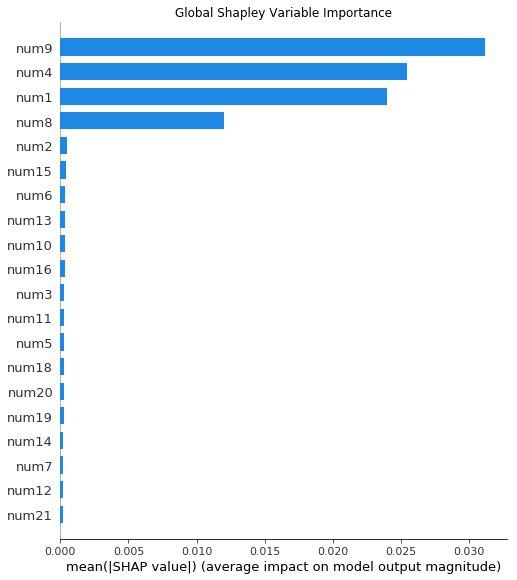

In [39]:
#Set all shapley values to their absolute value
shap_values_abs = np.absolute(shap_values[:,:,:-1])

#Plot mean absolute shapley across all classes for global shapley variable importance
# plt.title("Global Shapley Variable Importance")
# shap.summary_plot(shap_values_abs.mean(axis=1), test[xgb_model.feature_names], plot_type="bar", show=False)
# plt.savefig('./images/global_shapley.png',bbox_inches='tight')
# plt.close()

#To show in notebook
plt.title("Global Shapley Variable Importance")
shap.summary_plot(shap_values_abs.mean(axis=1), test[xgb_model.feature_names], plot_type="bar")

### Display Shapley variable importance summary per `target` class outcome

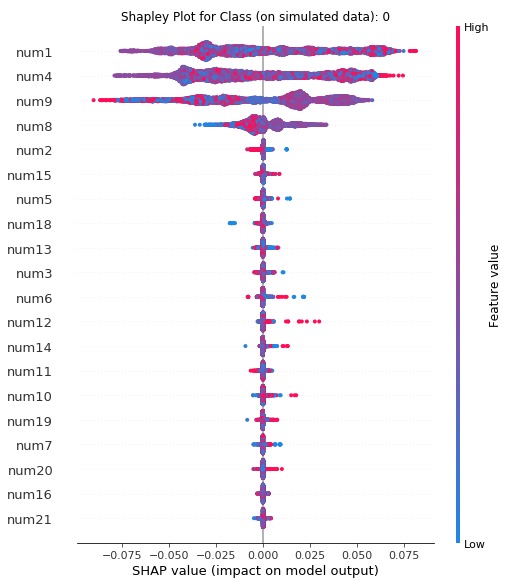

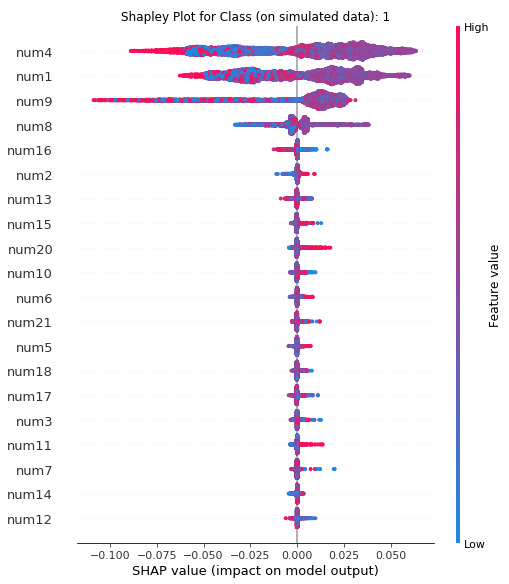

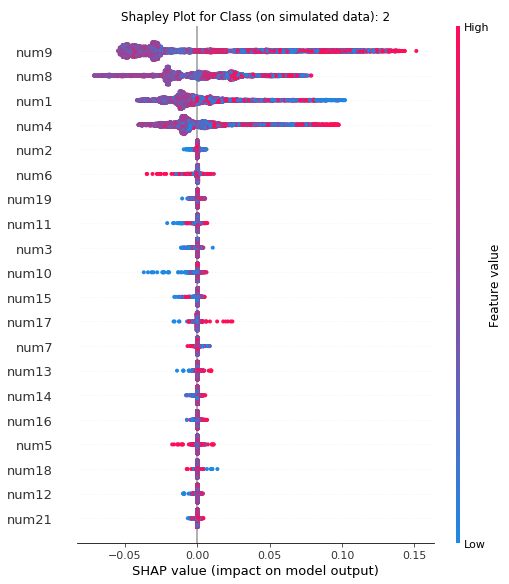

In [40]:
#Plot signed Shapley variable importance summary for a specific class (class 0, class 1, class2)
for i in range(0,3):
    plt.title("Shapley Plot for Class (on simulated data): " + str(i))
    shap.summary_plot(shap_values[:, i, :-1], test[xgb_model.feature_names], show=False)
    plt.savefig('./images/shapley_class_simulated' + str(i) + ".png", bbox_inches='tight')
    plt.close()
    #To show in notebook
    plt.title("Shapley Plot for Class (on simulated data): " + str(i))
    shap.summary_plot(shap_values[:, i, :-1], test[xgb_model.feature_names])

In [41]:
#Predict on test set
preds = xgb_model.predict(dtest)

In [42]:
#Display predictions as a Pandas frame
#Each column represents a class outcome for target: 0, 1, 2
pd.DataFrame(preds).head()

0         1         2
0  0.320520  0.379226  0.300254
1  0.317344  0.383481  0.299175
2  0.357945  0.338415  0.303639
3  0.318002  0.322698  0.359300
4  0.309554  0.350924  0.339522

### 2. Surrogate Decision Trees
#### 2.1 Pre-pruning

In [43]:
from skater.core.visualizer.tree_visualizer import plot_tree, tree_to_text
from skater.util.dataops import show_in_notebook

In [44]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.util.logger import _INFO, _DEBUG

interpreter = Interpretation(X_train_df, feature_names=feature_names)
model_inst = InMemoryModel(gbm.predict, examples=X_train_df, model_type='classifier', unique_values=[0, 1, 2],
                           feature_names=feature_names, target_names=target_names, log_level=_INFO)

In [45]:
# 1. Learner is trained on the decisions of the base model when use_oracle=True; when 'False' original labels are used
# to learn a more interpretable tree based model.

# 2. Learner uses F1 metric as the default metric of choice for classification.
# 3. set verbose=True for more detailed information
surrogate_explainer = interpreter.tree_surrogate(oracle=model_inst, class_weight="balanced", seed=5)
surrogate_explainer.fit(X_train_df, y_train, use_oracle=True, prune='pre', 
                        scorer_type='default')

2018-10-22 02:52:25,589 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-10-22 02:52:25,591 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2018-10-22 02:52:40,206 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (20946,)
2018-10-22 02:52:40,219 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.707; oracle score 0.789
2018-10-22 02:52:40,220 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.082 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower is the fidelity/faithfulness of the surrogate model


0.082

#### Evaluation on train and test using the Surrogate Tree(pre-pruning)

In [46]:
y_hat_train_s_pre = surrogate_explainer.predict(X_train_df)
y_hat_s_pre = surrogate_explainer.predict(X_test_df)

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_train, y_hat_train_s_pre, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_hat_s_pre, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.66      0.60      0.63      7055
    class 1       0.72      0.49      0.58      9489
    class 2       0.45      0.82      0.58      4402

avg / total       0.64      0.59      0.60     20946


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.65      0.59      0.61      2976
    class 1       0.70      0.49      0.57      4132
    class 2       0.45      0.80      0.58      1946

avg / total       0.63      0.59      0.59      9054



##### Conclusing using the Surrogate Tree with pre-pruning
From initial evaluation, it seems the performance of the model has reduced when using the simplified surrogate tree for evaluating the test dataset.

In [64]:
# Only the leaf notes(containing the respective class labels) are colored
surrogate_explainer.plot_global_decisions(colors=['royalblue', 'gray', 'red'], 
                                          file_name='simple_tree_prepruned_simulated.png')

2018-10-22 02:59:19,499 - skater.util.dataops - INFO - File Name: simple_tree_prepruned_simulated.png


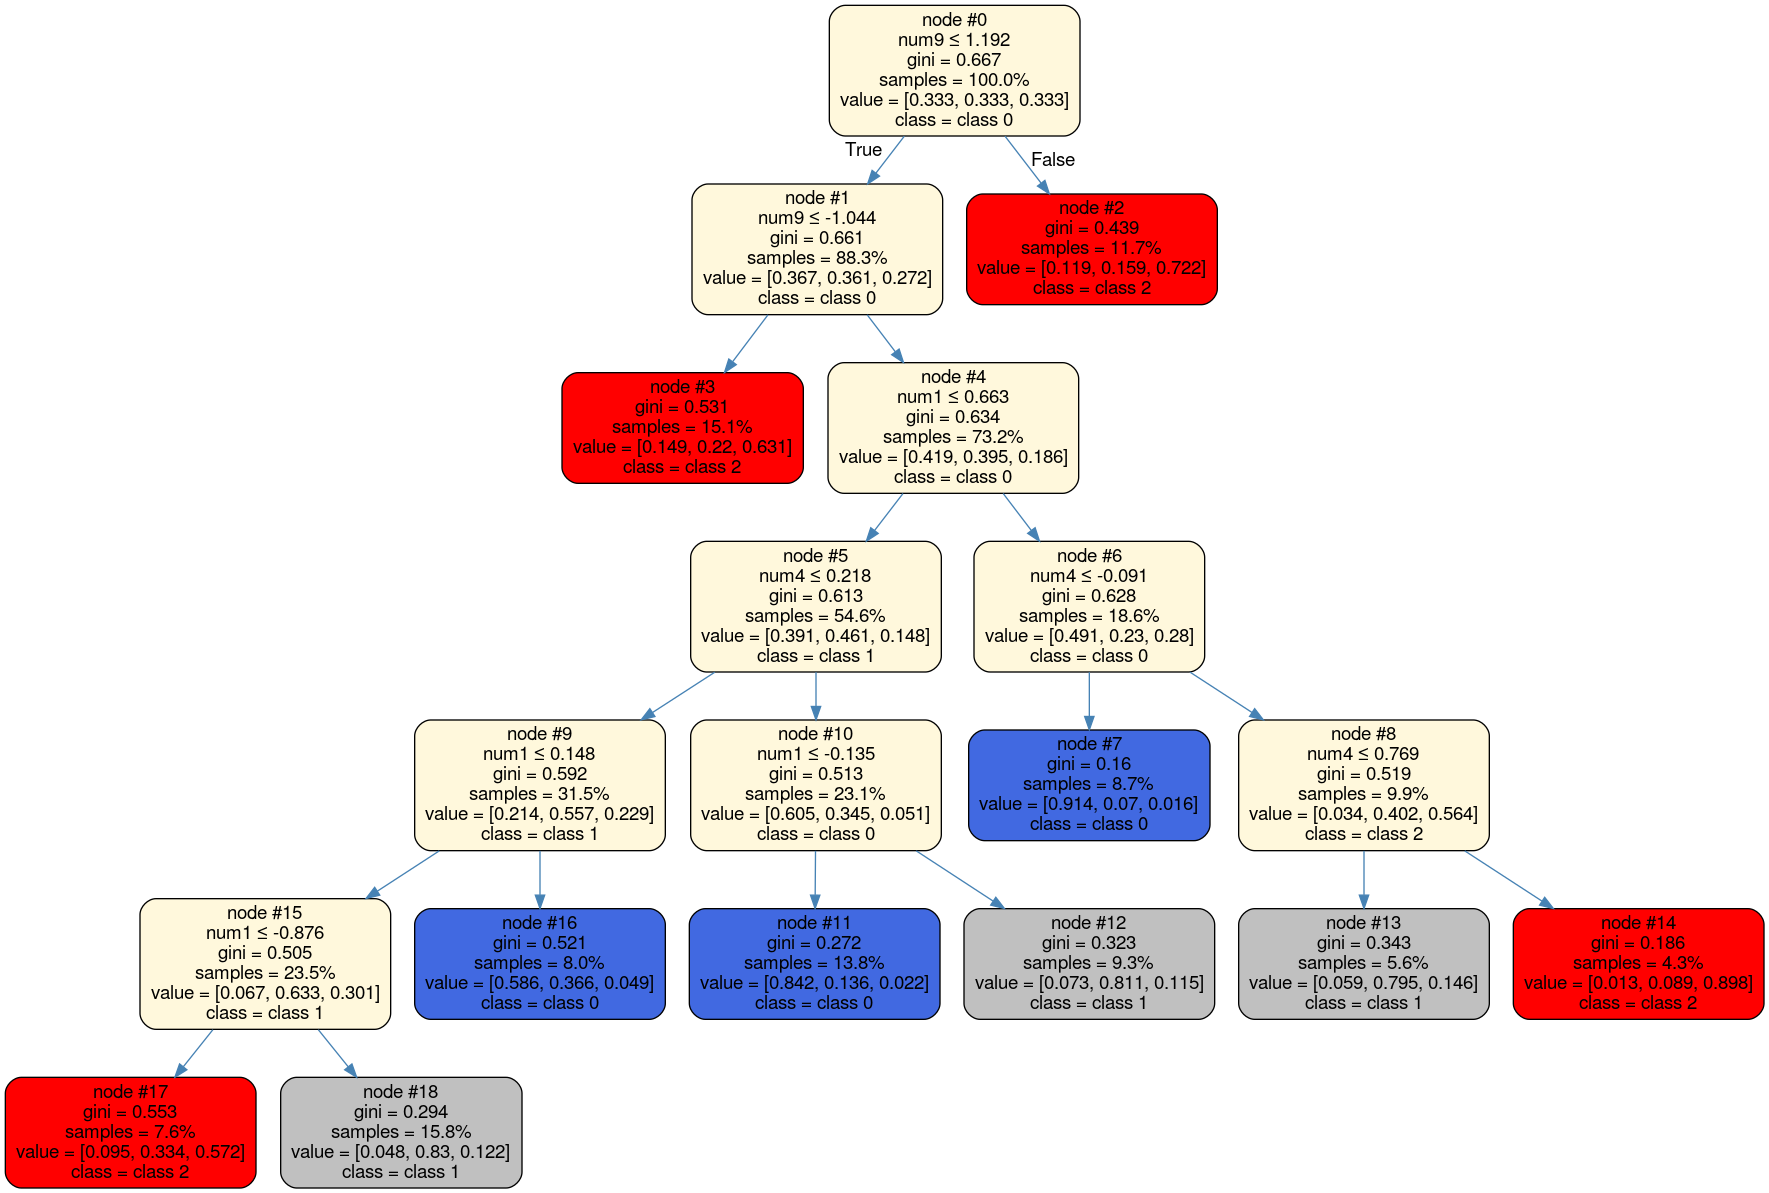

In [65]:
# Thing to notice here would be the fact that the node includes the top ranking features in the pre-pruned tree
# namely (num1, num4, num9)
%matplotlib inline
show_in_notebook('simple_tree_prepruned_simulated.png', width=600, height=500)

In [66]:
surrogate_explainer.decisions_as_txt()

if num9 <= 1.192431926727295 {
  if num9 <= -1.0435385704040527 {
      Predicted Label: 2
  } else {
    if num1 <= 0.6633080840110779 {
      if num4 <= 0.2180337905883789 {
        if num1 <= 0.14815638959407806 {
          if num1 <= -0.8763774037361145 {
              Predicted Label: 2
          } else {
              Predicted Label: 1
          }
        } else {
            Predicted Label: 0
        }
      } else {
        if num1 <= -0.13481079041957855 {
            Predicted Label: 0
        } else {
            Predicted Label: 1
        }
      }
    } else {
      if num4 <= -0.09122797846794128 {
          Predicted Label: 0
      } else {
        if num4 <= 0.7690187692642212 {
            Predicted Label: 1
        } else {
            Predicted Label: 2
        }
      }
    }
  }
} else {
    Predicted Label: 2
}


#### 2.2 Post pruning

In [112]:
interpreter = Interpretation(X_train_df, feature_names=feature_names)
model_inst = InMemoryModel(gbm.predict_proba, examples=X_train_df, model_type='classifier',
                           feature_names=feature_names, target_names=['0', '1', '2'], log_level=_INFO)
surrogate_explainer2 = interpreter.tree_surrogate(oracle=model_inst, class_weight="balanced", seed=5)
# One can control the impurity threshold parameter while constructing the tree. That may help in controling the size
# in-case the post-pruned tree is very big.
surrogate_explainer2.fit(X_train_df, y_train, use_oracle=True, prune='post', verbose=True, impurity_threshold=0.001)

2018-10-22 06:36:39,869 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2018-10-22 06:36:40,679 - skater.core.global_interpretation.tree_surrogate - DEBUG - Unique Labels in ground truth provided [0 1 2]
2018-10-22 06:36:40,681 - skater.core.global_interpretation.tree_surrogate - DEBUG - Probability scoring is enabled min:0.0/max:1.0
2018-10-22 06:36:40,682 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used cross-entropy
2018-10-22 06:36:40,691 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 2.1094237467877998e-15
2018-10-22 06:36:40,700 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 1.0986122886681353
2018-10-22 06:36:40,701 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 0 back
2018-10-22 06:36:40,711 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.9442689017747443
2018-10-22 06:36:40,712 - sk

2018-10-22 06:36:41,104 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0014901951305183853
2018-10-22 06:36:41,105 - skater.core.global_interpretation.tree_surrogate - DEBUG - Removed nodes: (index:53-->[left node: 54, right node: 55])
2018-10-22 06:36:41,117 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016273885431281848
2018-10-22 06:36:41,119 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 56 back
2018-10-22 06:36:41,131 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016639631473437475
2018-10-22 06:36:41,132 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 59 back
2018-10-22 06:36:41,144 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002259945247835873
2018-10-22 06:36:41,146 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 62 back
2018-10-22 06:36:41,158 - skater.core

2018-10-22 06:36:41,561 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015620897382249523
2018-10-22 06:36:41,562 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 120 back
2018-10-22 06:36:41,574 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017324769359254022
2018-10-22 06:36:41,576 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 123 back
2018-10-22 06:36:41,587 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015620897382249519
2018-10-22 06:36:41,589 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 124 back
2018-10-22 06:36:41,600 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015869423636688791
2018-10-22 06:36:41,602 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 133 back
2018-10-22 06:36:41,613 - skater.core.global_interpretation.tree_surroga

2018-10-22 06:36:42,015 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0030405820563654245
2018-10-22 06:36:42,016 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 194 back
2018-10-22 06:36:42,028 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001560844412180624
2018-10-22 06:36:42,029 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 195 back
2018-10-22 06:36:42,041 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002741822842454121
2018-10-22 06:36:42,042 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 198 back
2018-10-22 06:36:42,054 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0019599961146352946
2018-10-22 06:36:42,055 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 199 back
2018-10-22 06:36:42,067 - skater.core.global_interpretation.tree_surrogate

2018-10-22 06:36:42,472 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017655585800495208
2018-10-22 06:36:42,473 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 265 back
2018-10-22 06:36:42,485 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015869423636688791
2018-10-22 06:36:42,486 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 267 back
2018-10-22 06:36:42,498 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016052867966675137
2018-10-22 06:36:42,499 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 270 back
2018-10-22 06:36:42,512 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0023380731397157355
2018-10-22 06:36:42,513 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 273 back
2018-10-22 06:36:42,526 - skater.core.global_interpretation.tree_surroga

2018-10-22 06:36:42,929 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.004887923412192518
2018-10-22 06:36:42,931 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 336 back
2018-10-22 06:36:42,942 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0019659801237392246
2018-10-22 06:36:42,944 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 337 back
2018-10-22 06:36:42,956 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001627545267219851
2018-10-22 06:36:42,958 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 338 back
2018-10-22 06:36:42,970 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016050399834625399
2018-10-22 06:36:42,971 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 341 back
2018-10-22 06:36:42,983 - skater.core.global_interpretation.tree_surrogate

2018-10-22 06:36:43,384 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001812815644482037
2018-10-22 06:36:43,386 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 406 back
2018-10-22 06:36:43,398 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016835874849476825
2018-10-22 06:36:43,399 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 408 back
2018-10-22 06:36:43,412 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015620897382249523
2018-10-22 06:36:43,413 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 409 back
2018-10-22 06:36:43,425 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.004183328157973088
2018-10-22 06:36:43,427 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 413 back
2018-10-22 06:36:43,438 - skater.core.global_interpretation.tree_surrogate

2018-10-22 06:36:43,840 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002017055807529233
2018-10-22 06:36:43,841 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 477 back
2018-10-22 06:36:43,853 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001682040523178588
2018-10-22 06:36:43,854 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 478 back
2018-10-22 06:36:43,866 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015884438025425597
2018-10-22 06:36:43,867 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 481 back
2018-10-22 06:36:43,879 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.006928836993897222
2018-10-22 06:36:43,881 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 484 back
2018-10-22 06:36:43,892 - skater.core.global_interpretation.tree_surrogate 

2018-10-22 06:36:44,293 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0019371219879567615
2018-10-22 06:36:44,294 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 547 back
2018-10-22 06:36:44,305 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016487355563472258
2018-10-22 06:36:44,307 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 548 back
2018-10-22 06:36:44,319 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0024621841146896663
2018-10-22 06:36:44,320 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 552 back
2018-10-22 06:36:44,332 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001917455764105633
2018-10-22 06:36:44,333 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 553 back
2018-10-22 06:36:44,345 - skater.core.global_interpretation.tree_surrogat

2018-10-22 06:36:44,746 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.00257168310439053
2018-10-22 06:36:44,747 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 617 back
2018-10-22 06:36:44,759 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002342360967380974
2018-10-22 06:36:44,760 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 618 back
2018-10-22 06:36:44,772 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017648954039213172
2018-10-22 06:36:44,773 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 619 back
2018-10-22 06:36:44,785 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016589639705985129
2018-10-22 06:36:44,786 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 621 back
2018-10-22 06:36:44,798 - skater.core.global_interpretation.tree_surrogate 

2018-10-22 06:36:45,202 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016541232468381066
2018-10-22 06:36:45,203 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 687 back
2018-10-22 06:36:45,215 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015620897382249519
2018-10-22 06:36:45,216 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 689 back
2018-10-22 06:36:45,227 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016258324510918232
2018-10-22 06:36:45,228 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 692 back
2018-10-22 06:36:45,240 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.004253241630727839
2018-10-22 06:36:45,241 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 695 back
2018-10-22 06:36:45,253 - skater.core.global_interpretation.tree_surrogat

2018-10-22 06:36:45,655 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015620897382249519
2018-10-22 06:36:45,656 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 755 back
2018-10-22 06:36:45,669 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0023981964829149806
2018-10-22 06:36:45,670 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 758 back
2018-10-22 06:36:45,682 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015884438025425601
2018-10-22 06:36:45,684 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 759 back
2018-10-22 06:36:45,696 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002209959714496522
2018-10-22 06:36:45,697 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 762 back
2018-10-22 06:36:45,709 - skater.core.global_interpretation.tree_surrogat

2018-10-22 06:36:46,120 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016072608568108125
2018-10-22 06:36:46,121 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 820 back
2018-10-22 06:36:46,132 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015977020062879457
2018-10-22 06:36:46,133 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 824 back
2018-10-22 06:36:46,145 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001633984345931519
2018-10-22 06:36:46,146 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 827 back
2018-10-22 06:36:46,157 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.012957447328284273
2018-10-22 06:36:46,159 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 832 back
2018-10-22 06:36:46,170 - skater.core.global_interpretation.tree_surrogate

2018-10-22 06:36:46,576 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.00428101146904369
2018-10-22 06:36:46,577 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 893 back
2018-10-22 06:36:46,589 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0025189699919393213
2018-10-22 06:36:46,590 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 894 back
2018-10-22 06:36:46,601 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0023032917403106707
2018-10-22 06:36:46,603 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 895 back
2018-10-22 06:36:46,614 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0021209213581901546
2018-10-22 06:36:46,616 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 897 back
2018-10-22 06:36:46,627 - skater.core.global_interpretation.tree_surrogate

2018-10-22 06:36:47,026 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0023586087279961155
2018-10-22 06:36:47,027 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 966 back
2018-10-22 06:36:47,038 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017203784628166418
2018-10-22 06:36:47,039 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 968 back
2018-10-22 06:36:47,049 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016356994560707545
2018-10-22 06:36:47,051 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 970 back
2018-10-22 06:36:47,061 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.009423118547325745
2018-10-22 06:36:47,063 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 973 back
2018-10-22 06:36:47,074 - skater.core.global_interpretation.tree_surrogat

2018-10-22 06:36:47,453 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.003880770226775411
2018-10-22 06:36:47,455 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1035 back
2018-10-22 06:36:47,466 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.003542353260213153
2018-10-22 06:36:47,468 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1036 back
2018-10-22 06:36:47,479 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0033039369186349354
2018-10-22 06:36:47,480 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1038 back
2018-10-22 06:36:47,492 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.003043012125008049
2018-10-22 06:36:47,493 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1040 back
2018-10-22 06:36:47,504 - skater.core.global_interpretation.tree_surrog

2018-10-22 06:36:47,885 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016050399834625403
2018-10-22 06:36:47,887 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1102 back
2018-10-22 06:36:47,897 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001560844412180624
2018-10-22 06:36:47,899 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1106 back
2018-10-22 06:36:47,910 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.003263514721667666
2018-10-22 06:36:47,911 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1110 back
2018-10-22 06:36:47,922 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002288875138000914
2018-10-22 06:36:47,923 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1111 back
2018-10-22 06:36:47,934 - skater.core.global_interpretation.tree_surrog

2018-10-22 06:36:48,316 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.008870474347349316
2018-10-22 06:36:48,317 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1172 back
2018-10-22 06:36:48,329 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.005822696624081205
2018-10-22 06:36:48,331 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1173 back
2018-10-22 06:36:48,342 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.004717866223708622
2018-10-22 06:36:48,344 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1174 back
2018-10-22 06:36:48,354 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0035152038475451926
2018-10-22 06:36:48,356 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1175 back
2018-10-22 06:36:48,367 - skater.core.global_interpretation.tree_surrog

2018-10-22 06:36:48,748 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001688182304065829
2018-10-22 06:36:48,749 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1245 back
2018-10-22 06:36:48,760 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0036365604144941474
2018-10-22 06:36:48,762 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1248 back
2018-10-22 06:36:48,772 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0029305846547830867
2018-10-22 06:36:48,774 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1249 back
2018-10-22 06:36:48,784 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001649527510709922
2018-10-22 06:36:48,786 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1250 back
2018-10-22 06:36:48,798 - skater.core.global_interpretation.tree_surro

2018-10-22 06:36:49,188 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.005459202192200421
2018-10-22 06:36:49,189 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1316 back
2018-10-22 06:36:49,200 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0019548218296338397
2018-10-22 06:36:49,202 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1317 back
2018-10-22 06:36:49,213 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.00164266129677291
2018-10-22 06:36:49,214 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1318 back
2018-10-22 06:36:49,225 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.004332454542035952
2018-10-22 06:36:49,226 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1322 back
2018-10-22 06:36:49,237 - skater.core.global_interpretation.tree_surroga

2018-10-22 06:36:49,623 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016278768552839531
2018-10-22 06:36:49,624 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1383 back
2018-10-22 06:36:49,635 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017614697716652609
2018-10-22 06:36:49,637 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1386 back
2018-10-22 06:36:49,648 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016571668111705529
2018-10-22 06:36:49,649 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1388 back
2018-10-22 06:36:49,660 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002212198242826705
2018-10-22 06:36:49,662 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1391 back
2018-10-22 06:36:49,672 - skater.core.global_interpretation.tree_surr

2018-10-22 06:36:50,234 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017266602913710322
2018-10-22 06:36:50,249 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1456 back
2018-10-22 06:36:50,262 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001560844412180624
2018-10-22 06:36:50,277 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1458 back
2018-10-22 06:36:50,305 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0022066187687162114
2018-10-22 06:36:50,317 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1461 back
2018-10-22 06:36:50,331 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0019548218296338397
2018-10-22 06:36:50,345 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1463 back
2018-10-22 06:36:50,361 - skater.core.global_interpretation.tree_surr

2018-10-22 06:36:51,092 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001560844412180624
2018-10-22 06:36:51,096 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1524 back
2018-10-22 06:36:51,120 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001633984345931519
2018-10-22 06:36:51,129 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1527 back
2018-10-22 06:36:51,152 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015869423636688791
2018-10-22 06:36:51,160 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1530 back
2018-10-22 06:36:51,180 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0070638261827834945
2018-10-22 06:36:51,193 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1534 back
2018-10-22 06:36:51,211 - skater.core.global_interpretation.tree_surro

2018-10-22 06:36:51,668 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0023598055885235398
2018-10-22 06:36:51,669 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1597 back
2018-10-22 06:36:51,680 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016389826011347292
2018-10-22 06:36:51,681 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1598 back
2018-10-22 06:36:51,692 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0021070000059875485
2018-10-22 06:36:51,694 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1601 back
2018-10-22 06:36:51,705 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0018742643468422802
2018-10-22 06:36:51,706 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1603 back
2018-10-22 06:36:51,717 - skater.core.global_interpretation.tree_sur

2018-10-22 06:36:52,100 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.003363285060144093
2018-10-22 06:36:52,101 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1665 back
2018-10-22 06:36:52,112 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0026388932242301802
2018-10-22 06:36:52,114 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1667 back
2018-10-22 06:36:52,125 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0018518563698395724
2018-10-22 06:36:52,126 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1668 back
2018-10-22 06:36:52,137 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017034387361325343
2018-10-22 06:36:52,139 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1669 back
2018-10-22 06:36:52,150 - skater.core.global_interpretation.tree_surr

2018-10-22 06:36:52,546 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001560844412180624
2018-10-22 06:36:52,548 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1731 back
2018-10-22 06:36:52,565 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.005877935373416254
2018-10-22 06:36:52,567 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1737 back
2018-10-22 06:36:52,578 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002563978111326933
2018-10-22 06:36:52,579 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1738 back
2018-10-22 06:36:52,591 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0020755732632176563
2018-10-22 06:36:52,592 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1740 back
2018-10-22 06:36:52,604 - skater.core.global_interpretation.tree_surrog

2018-10-22 06:36:52,986 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015869423636688791
2018-10-22 06:36:52,988 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1802 back
2018-10-22 06:36:52,999 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0018157819140025983
2018-10-22 06:36:53,000 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1806 back
2018-10-22 06:36:53,017 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016469602523945305
2018-10-22 06:36:53,019 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1807 back
2018-10-22 06:36:53,030 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0029883959217333195
2018-10-22 06:36:53,031 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1811 back
2018-10-22 06:36:53,042 - skater.core.global_interpretation.tree_sur

2018-10-22 06:36:53,440 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.003661396528991724
2018-10-22 06:36:53,442 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1876 back
2018-10-22 06:36:53,454 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0018584876915645496
2018-10-22 06:36:53,455 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1877 back
2018-10-22 06:36:53,467 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017333008429820356
2018-10-22 06:36:53,468 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1879 back
2018-10-22 06:36:53,480 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016160300017572836
2018-10-22 06:36:53,481 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1880 back
2018-10-22 06:36:53,492 - skater.core.global_interpretation.tree_surr

2018-10-22 06:36:53,886 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0020177325722881296
2018-10-22 06:36:53,887 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1947 back
2018-10-22 06:36:53,898 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017521254139797506
2018-10-22 06:36:53,899 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1948 back
2018-10-22 06:36:53,910 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001560844412180624
2018-10-22 06:36:53,911 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1949 back
2018-10-22 06:36:53,922 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.00190239765616902
2018-10-22 06:36:53,924 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 1954 back
2018-10-22 06:36:53,935 - skater.core.global_interpretation.tree_surrog

2018-10-22 06:36:54,313 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016852952544886516
2018-10-22 06:36:54,314 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2017 back
2018-10-22 06:36:54,325 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0026958443348967624
2018-10-22 06:36:54,326 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2020 back
2018-10-22 06:36:54,337 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0023427582054038605
2018-10-22 06:36:54,338 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2021 back
2018-10-22 06:36:54,349 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0022135176091607586
2018-10-22 06:36:54,350 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2023 back
2018-10-22 06:36:54,361 - skater.core.global_interpretation.tree_sur

2018-10-22 06:36:54,746 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0027766710223911663
2018-10-22 06:36:54,748 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2086 back
2018-10-22 06:36:54,758 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0024858326699655235
2018-10-22 06:36:54,759 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2087 back
2018-10-22 06:36:54,770 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017041075738125722
2018-10-22 06:36:54,771 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2088 back
2018-10-22 06:36:54,782 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.00198644034942651
2018-10-22 06:36:54,783 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2091 back
2018-10-22 06:36:54,794 - skater.core.global_interpretation.tree_surro

2018-10-22 06:36:55,180 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0023046522949286084
2018-10-22 06:36:55,182 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2158 back
2018-10-22 06:36:55,193 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017381698991991653
2018-10-22 06:36:55,194 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2159 back
2018-10-22 06:36:55,205 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0018613489844255295
2018-10-22 06:36:55,206 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2162 back
2018-10-22 06:36:55,217 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016633586442603061
2018-10-22 06:36:55,219 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2163 back
2018-10-22 06:36:55,229 - skater.core.global_interpretation.tree_sur

2018-10-22 06:36:55,606 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.027196272210879974
2018-10-22 06:36:55,608 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2229 back
2018-10-22 06:36:55,619 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.00943004767716682
2018-10-22 06:36:55,620 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2230 back
2018-10-22 06:36:55,631 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002713948013714411
2018-10-22 06:36:55,632 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2231 back
2018-10-22 06:36:55,643 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0025819710133551453
2018-10-22 06:36:55,645 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2232 back
2018-10-22 06:36:55,655 - skater.core.global_interpretation.tree_surroga

2018-10-22 06:36:56,035 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.006921148130248859
2018-10-22 06:36:56,037 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2297 back
2018-10-22 06:36:56,047 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.003034045152711635
2018-10-22 06:36:56,049 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2298 back
2018-10-22 06:36:56,059 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017018868947366605
2018-10-22 06:36:56,060 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2299 back
2018-10-22 06:36:56,071 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016258324510918232
2018-10-22 06:36:56,072 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2300 back
2018-10-22 06:36:56,083 - skater.core.global_interpretation.tree_surro

2018-10-22 06:36:56,476 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017511359593591958
2018-10-22 06:36:56,477 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2366 back
2018-10-22 06:36:56,488 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015869423636688791
2018-10-22 06:36:56,489 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2367 back
2018-10-22 06:36:56,500 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0029476437957051704
2018-10-22 06:36:56,501 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2372 back
2018-10-22 06:36:56,511 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002320697148017485
2018-10-22 06:36:56,513 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2373 back
2018-10-22 06:36:56,524 - skater.core.global_interpretation.tree_surr

2018-10-22 06:36:56,911 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017896200611445872
2018-10-22 06:36:56,913 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2436 back
2018-10-22 06:36:56,924 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015869423636688791
2018-10-22 06:36:56,926 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2437 back
2018-10-22 06:36:56,937 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016409012810656822
2018-10-22 06:36:56,938 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2441 back
2018-10-22 06:36:56,950 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002290508006186258
2018-10-22 06:36:56,951 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2444 back
2018-10-22 06:36:56,962 - skater.core.global_interpretation.tree_surr

2018-10-22 06:36:57,348 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.008466896104480136
2018-10-22 06:36:57,349 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2508 back
2018-10-22 06:36:57,365 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0059033028516680104
2018-10-22 06:36:57,366 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2509 back
2018-10-22 06:36:57,376 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0018082369182298302
2018-10-22 06:36:57,378 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2510 back
2018-10-22 06:36:57,388 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016052867966675137
2018-10-22 06:36:57,390 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2511 back
2018-10-22 06:36:57,400 - skater.core.global_interpretation.tree_surr

2018-10-22 06:36:57,780 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016487355563472258
2018-10-22 06:36:57,781 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2578 back
2018-10-22 06:36:57,791 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.00688718351346971
2018-10-22 06:36:57,793 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2582 back
2018-10-22 06:36:57,804 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0024753708929701125
2018-10-22 06:36:57,805 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2583 back
2018-10-22 06:36:57,815 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002078447047336948
2018-10-22 06:36:57,817 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2584 back
2018-10-22 06:36:57,828 - skater.core.global_interpretation.tree_surrog

2018-10-22 06:36:58,206 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002451646087428646
2018-10-22 06:36:58,207 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2649 back
2018-10-22 06:36:58,219 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0021407436644918353
2018-10-22 06:36:58,220 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2650 back
2018-10-22 06:36:58,231 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002017845565463118
2018-10-22 06:36:58,232 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2652 back
2018-10-22 06:36:58,243 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001879689212482239
2018-10-22 06:36:58,244 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2654 back
2018-10-22 06:36:58,256 - skater.core.global_interpretation.tree_surrog

2018-10-22 06:36:58,633 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015620897382249519
2018-10-22 06:36:58,635 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2718 back
2018-10-22 06:36:58,645 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0020118996358920445
2018-10-22 06:36:58,647 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2721 back
2018-10-22 06:36:58,659 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017836779389546998
2018-10-22 06:36:58,660 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2722 back
2018-10-22 06:36:58,672 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016356994560707545
2018-10-22 06:36:58,673 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2723 back
2018-10-22 06:36:58,684 - skater.core.global_interpretation.tree_sur

2018-10-22 06:36:59,062 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0027931148246790544
2018-10-22 06:36:59,063 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2783 back
2018-10-22 06:36:59,074 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016052867966675137
2018-10-22 06:36:59,075 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2784 back
2018-10-22 06:36:59,086 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0025733200075941883
2018-10-22 06:36:59,088 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2787 back
2018-10-22 06:36:59,098 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016052867966675137
2018-10-22 06:36:59,100 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2788 back
2018-10-22 06:36:59,111 - skater.core.global_interpretation.tree_sur

2018-10-22 06:36:59,487 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016036748438785853
2018-10-22 06:36:59,489 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2857 back
2018-10-22 06:36:59,499 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.003001784553817108
2018-10-22 06:36:59,501 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2861 back
2018-10-22 06:36:59,512 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002263682625402194
2018-10-22 06:36:59,513 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2862 back
2018-10-22 06:36:59,524 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0018021923339273562
2018-10-22 06:36:59,525 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2863 back
2018-10-22 06:36:59,536 - skater.core.global_interpretation.tree_surro

2018-10-22 06:36:59,911 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002492025214431391
2018-10-22 06:36:59,912 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2927 back
2018-10-22 06:36:59,923 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0018047785203629942
2018-10-22 06:36:59,924 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2928 back
2018-10-22 06:36:59,935 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016258324510918232
2018-10-22 06:36:59,936 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2929 back
2018-10-22 06:36:59,947 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0019184094734218142
2018-10-22 06:36:59,948 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2933 back
2018-10-22 06:36:59,959 - skater.core.global_interpretation.tree_surr

2018-10-22 06:37:00,336 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0017275515567791821
2018-10-22 06:37:00,337 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 2999 back
2018-10-22 06:37:00,348 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0015869423636688791
2018-10-22 06:37:00,350 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3001 back
2018-10-22 06:37:00,361 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.006772357547707854
2018-10-22 06:37:00,362 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3004 back
2018-10-22 06:37:00,373 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0037592589715553146
2018-10-22 06:37:00,374 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3005 back
2018-10-22 06:37:00,385 - skater.core.global_interpretation.tree_surr

2018-10-22 06:37:00,764 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0025224890393985367
2018-10-22 06:37:00,765 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3067 back
2018-10-22 06:37:00,776 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.001972786396238944
2018-10-22 06:37:00,777 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3069 back
2018-10-22 06:37:00,788 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0016754319905332759
2018-10-22 06:37:00,789 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3070 back
2018-10-22 06:37:00,800 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0018157819140025983
2018-10-22 06:37:00,802 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3074 back
2018-10-22 06:37:00,813 - skater.core.global_interpretation.tree_surr

2018-10-22 06:37:01,262 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.025282200852835945
2018-10-22 06:37:01,263 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3142 back
2018-10-22 06:37:01,274 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.012462568603572706
2018-10-22 06:37:01,275 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3143 back
2018-10-22 06:37:01,287 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.006347175434977604
2018-10-22 06:37:01,288 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3144 back
2018-10-22 06:37:01,299 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.004274975942237542
2018-10-22 06:37:01,300 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3145 back
2018-10-22 06:37:01,311 - skater.core.global_interpretation.tree_surroga

2018-10-22 06:37:01,692 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.003709582893021738
2018-10-22 06:37:01,693 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3209 back
2018-10-22 06:37:01,704 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0035358682716406667
2018-10-22 06:37:01,705 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3211 back
2018-10-22 06:37:01,716 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.003191258572642932
2018-10-22 06:37:01,718 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3212 back
2018-10-22 06:37:01,729 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.003031943593000383
2018-10-22 06:37:01,730 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3214 back
2018-10-22 06:37:01,741 - skater.core.global_interpretation.tree_surrog

2018-10-22 06:37:02,121 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.005048279126972552
2018-10-22 06:37:02,122 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3275 back
2018-10-22 06:37:02,133 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0031516245326073805
2018-10-22 06:37:02,134 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3276 back
2018-10-22 06:37:02,145 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.002691699264027947
2018-10-22 06:37:02,146 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3277 back
2018-10-22 06:37:02,157 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.0023575697035264466
2018-10-22 06:37:02,158 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 3278 back
2018-10-22 06:37:02,169 - skater.core.global_interpretation.tree_surro

0.559

In [113]:
# colors could be set to 'None' for randomly selecting the colors
surrogate_explainer2.plot_global_decisions(colors=['deepskyblue', 'gray', 'red'], 
                                          file_name='simple_tree_postpruned_simulated.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.233383 to fit



2018-10-22 02:56:33,508 - skater.util.dataops - INFO - File Name: simple_tree_postpruned_simulated.png


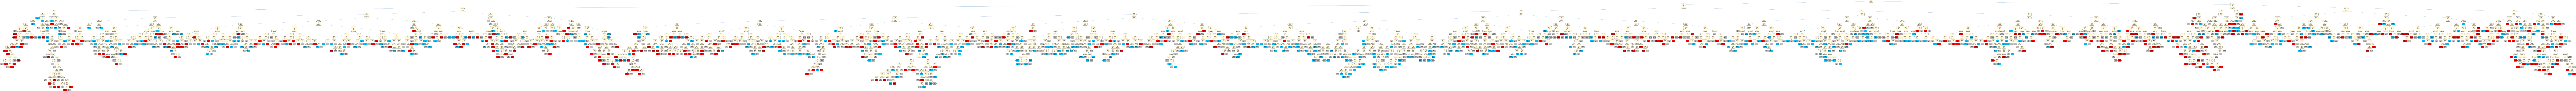

In [52]:
%matplotlib inline
show_in_notebook('simple_tree_postpruned_simulated.png', width=300, height=300)

In [114]:
# Trees could get busy very quickly. In that case, we need alternatives to visualize them in a more convenient way. 
# Text representation may be a convenient choice in that case.
surrogate_explainer2.decisions_as_txt()

if num9 <= 1.192431926727295 {
  if num9 <= -1.0435385704040527 {
    if num8 <= -0.7409917712211609 {
      if num9 <= -1.279954195022583 {
        if num4 <= -2.213245391845703 {
          if num10 <= -0.19148999452590942 {
        } else {
          if num5 <= 2.54449462890625 {
            if num14 <= 2.4725308418273926 {
              if num19 <= 1.7480604648590088 {
                if num21 <= -2.89536714553833 {
                    Predicted Label: 1
                } else {
                  if num5 <= -2.794595718383789 {
                    if num12 <= -0.07685640454292297 {
                  } else {
                    if num21 <= -1.7799582481384277 {
                      if num19 <= 0.5186925530433655 {
                    } else {
                      if num7 <= 1.9658042192459106 {
                        if num8 <= -0.7509602308273315 {
                          if num3 <= 2.4309210777282715 {
                            if num15 <= -1.62257981300354 {
              

                                                  if num18 <= 0.19073085486888885 {
                                                      Predicted Label: 2
                                                  } else {
                                                      Predicted Label: 1
                                                  }
                                                } else {
                                                  if num11 <= -1.6521503925323486 {
                                                    if num2 <= 0.5148985385894775 {
                                                        Predicted Label: 2
                                                    } else {
                                                        Predicted Label: 1
                                                    }
                                                  } else {
                                                      Predicted Label: 2
                                     

                  } else {
                    if num3 <= -0.9368565082550049 {
                      if num21 <= 0.7911319732666016 {
                          Predicted Label: 0
                      } else {
                          Predicted Label: 1
                      }
                    } else {
                      if num12 <= 1.056272029876709 {
                        if num16 <= 0.6275222301483154 {
                          if num1 <= -2.1581902503967285 {
                              Predicted Label: 0
                          } else {
                            if num5 <= 1.1673880815505981 {
                              if num3 <= 1.6888401508331299 {
                                if num2 <= -2.4238739013671875 {
                                    Predicted Label: 1
                                } else {
                                  if num20 <= -1.0878961086273193 {
                                      Predicted Label: 1
                             

                          Predicted Label: 1
                      } else {
                        if num3 <= 0.700421929359436 {
                            Predicted Label: 2
                        } else {
                            Predicted Label: 1
                        }
                      }
                    }
                  } else {
                    if num1 <= -1.2769122123718262 {
                        Predicted Label: 2
                    } else {
                      if num18 <= 0.08877933025360107 {
                        if num13 <= -1.025498867034912 {
                            Predicted Label: 1
                        } else {
                            Predicted Label: 0
                        }
                      } else {
                        if num12 <= 0.9660110473632812 {
                            Predicted Label: 2
                        } else {
                          if num4 <= -0.986508309841156 {
                          

                        if num2 <= 1.0585267543792725 {
                            Predicted Label: 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


num7 <= 0.6351332664489746 {
                  if num15 <= -1.2398052215576172 {
                    if num20 <= -0.038916975259780884 {
                        Predicted Label: 0
                    } else {
                        Predicted Label: 2
                    }
                  } else {
                    if num5 <= 1.9283785820007324 {
                      if num14 <= 1.6521871089935303 {
                        if num15 <= 1.2687664031982422 {
                            Predicted Label: 2
                        } else {
                          if num3 <= -0.2707788050174713 {
                              Predicted Label: 0
                          } else {
                              Predicted Label: 2
                          }
                        }
                      } else {
                        if num3 <= -0.8675850629806519 {
                            Predicted Label: 2
                        } else {
                            Predicted Lab

                      } else {
                        if num3 <= -1.5173976421356201 {
                            Predicted Label: 2
                        } else {
                            Predicted Label: 1
                        }
                      }
                    } else {
                      if num18 <= 1.9174283742904663 {
                        if num7 <= 2.9756054878234863 {
                          if num5 <= -2.175551414489746 {
                              Predicted Label: 0
                          } else {
                            if num4 <= 0.62819504737854 {
                                Predicted Label: 1
                            } else {
                              if num15 <= 0.530342698097229 {
                                  Predicted Label: 1
                              } else {
                                  Predicted Label: 2
                              }
                            }
                          }
          

                              if num6 <= 0.25026634335517883 {
                                  Predicted Label: 2
                              } else {
                                  Predicted Label: 1
                              }
                            }
                          }
                        }
                      } else {
                        if num7 <= -0.36282995343208313 {
                            Predicted Label: 1
                        } else {
                          if num6 <= -1.4181863069534302 {
                              Predicted Label: 1
                          } else {
                              Predicted Label: 2
                          }
                        }
                      }
                    } else {
                        Predicted Label: 0
                    }
                  } else {
                      Predicted Label: 0
                  }
                }
              }
            }
       

                            } else {
                              if num21 <= 1.2185661792755127 {
                                  Predicted Label: 1
                              } else {
                                  Predicted Label: 2
                              }
                            }
                          }
                        }
                      }
                    } else {
                      if num16 <= 0.2522125542163849 {
                          Predicted Label: 0
                      } else {
                          Predicted Label: 2
                      }
                    }
                  } else {
                    if num3 <= -1.4121873378753662 {
                        Predicted Label: 2
                    } else {
                        Predicted Label: 0
                    }
                  }
                } else {
                  if num5 <= -1.5174552202224731 {
                    if num13 <= -0.5348113179206848

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.



                            }
                          } else {
                            if num19 <= 2.871366500854492 {
                              if num8 <= -2.2120461463928223 {
                                if num4 <= -1.596437692642212 {
                                    Predicted Label: 2
                                } else {
                                    Predicted Label: 1
                                }
                              } else {
                                if num5 <= -2.2795300483703613 {
                                  if num8 <= -0.6870516538619995 {
                                      Predicted Label: 0
                                  } else {
                                      Predicted Label: 1
                                  }
                                } else {
                                    Predicted Label: 1
                                }
                              }
                            } else {

                                                Predicted Label: 1
                                            }
                                          }
                                        } else {
                                            Predicted Label: 0
                                        }
                                      } else {
                                        if num6 <= -0.8871670961380005 {
                                          if num5 <= 0.5662052631378174 {
                                            if num7 <= 1.3829519748687744 {
                                                Predicted Label: 0
                                            } else {
                                                Predicted Label: 1
                                            }
                                          } else {
                                              Predicted Label: 1
                                          }
                          

                          } else {
                              Predicted Label: 1
                          }
                        }
                      } else {
                        if num12 <= -1.8093574047088623 {
                            Predicted Label: 0
                        } else {
                            Predicted Label: 1
                        }
                      }
                    }
                  } else {
                    if num8 <= 1.8236093521118164 {
                      if num17 <= 1.4409935474395752 {
                        if num1 <= -0.3045353591442108 {
                          if num1 <= -0.3145202398300171 {
                            if num18 <= 1.114118218421936 {
                              if num6 <= 1.6822781562805176 {
                                  Predicted Label: 1
                              } else {
                                  Predicted Label: 0
                              }
                         

                                  if num4 <= -0.7142009735107422 {
                                      Predicted Label: 0
                                  } else {
                                    if num1 <= 0.18506693840026855 {
                                        Predicted Label: 0
                                    } else {
                                        Predicted Label: 1
                                    }
                                  }
                                } else {
                                  if num21 <= -1.8120934963226318 {
                                    if num5 <= 0.5438205599784851 {
                                        Predicted Label: 0
                                    } else {
                                        Predicted Label: 1
                                    }
                                  } else {
                                      Predicted Label: 0
                                  }
             

                      if num17 <= 0.9393457174301147 {
                        if num7 <= -0.580387532711029 {
                          if num19 <= -0.8539922833442688 {
                              Predicted Label: 2
                          } else {
                              Predicted Label: 1
                          }
                        } else {
                            Predicted Label: 2
                        }
                      } else {
                          Predicted Label: 1
                      }
                    }
                  }
                } else {
                  if num8 <= -0.5858559608459473 {
                    if num8 <= -1.2607457637786865 {
                      if num9 <= 0.940392255783081 {
                        if num20 <= -0.13964691758155823 {
                            Predicted Label: 0
                        } else {
                            Predicted Label: 1
                        }
                      } el

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.



                        }
                      } else {
                          Predicted Label: 1
                      }
                    } else {
                      if num8 <= -1.7054623365402222 {
                        if num11 <= -0.8674455285072327 {
                            Predicted Label: 0
                        } else {
                          if num20 <= 0.5541733503341675 {
                              Predicted Label: 1
                          } else {
                              Predicted Label: 2
                          }
                        }
                      } else {
                        if num18 <= -1.7375380992889404 {
                          if num9 <= -0.883343517780304 {
                              Predicted Label: 0
                          } else {
                              Predicted Label: 1
                          }
                        } else {
                            Predicted Label: 0
                 

                              if num4 <= 0.521848738193512 {
                                  Predicted Label: 1
                              } else {
                                if num8 <= 0.8847728967666626 {
                                  if num5 <= -1.3330717086791992 {
                                      Predicted Label: 1
                                  } else {
                                      Predicted Label: 0
                                  }
                                } else {
                                    Predicted Label: 1
                                }
                              }
                            }
                          } else {
                            if num8 <= -1.7664527893066406 {
                              if num9 <= 0.5264730453491211 {
                                if num1 <= -0.595086932182312 {
                                    Predicted Label: 0
                                } else {
             

                                }
                              }
                            } else {
                                Predicted Label: 1
                            }
                          } else {
                            if num20 <= 0.1903272569179535 {
                                Predicted Label: 1
                            } else {
                              if num11 <= 0.09996466338634491 {
                                  Predicted Label: 0
                              } else {
                                  Predicted Label: 1
                              }
                            }
                          }
                        }
                      } else {
                          Predicted Label: 1
                      }
                    }
                  } else {
                      Predicted Label: 1
                  }
                } else {
                  if num9 <= -0.49935299158096313 {
                    

                        if num8 <= -0.9235889911651611 {
                          if num6 <= -0.6430325508117676 {
                              Predicted Label: 0
                          } else {
                              Predicted Label: 1
                          }
                        } else {
                          if num21 <= 1.7357685565948486 {
                            if num20 <= -1.6652730703353882 {
                              if num12 <= 0.836222767829895 {
                                  Predicted Label: 1
                              } else {
                                  Predicted Label: 0
                              }
                            } else {
                                Predicted Label: 0
                            }
                          } else {
                              Predicted Label: 1
                          }
                        }
                      }
                    }
                  }
        

                    if num4 <= 0.6790165305137634 {
                      if num19 <= -0.9532872438430786 {
                          Predicted Label: 0
                      } else {
                          Predicted Label: 1
                      }
                    } else {
                      if num8 <= 0.2830054461956024 {
                        if num6 <= -2.960986614227295 {
                            Predicted Label: 1
                        } else {
                          if num1 <= -0.15057159960269928 {
                            if num17 <= 1.5043954849243164 {
                              if num8 <= -0.4697182774543762 {
                                if num12 <= -0.20559221506118774 {
                                    Predicted Label: 0
                                } else {
                                    Predicted Label: 1
                                }
                              } else {
                                  Predicted Label: 0


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.



                        Predicted Label: 1
                    }
                  } else {
                    if num7 <= 0.3429948091506958 {
                        Predicted Label: 2
                    } else {
                        Predicted Label: 1
                    }
                  }
                } else {
                  if num4 <= 3.5924501419067383 {
                    if num9 <= 0.8686151504516602 {
                        Predicted Label: 1
                    } else {
                      if num20 <= -0.9772845506668091 {
                          Predicted Label: 2
                      } else {
                        if num16 <= 1.2946925163269043 {
                            Predicted Label: 1
                        } else {
                            Predicted Label: 0
                        }
                      }
                    }
                  } else {
                      Predicted Label: 2
                  }
                }
     

            if num4 <= -0.13462713360786438 {
              if num9 <= 0.6729030609130859 {
                if num4 <= -0.3535696268081665 {
                  if num18 <= -2.3924646377563477 {
                    if num1 <= 2.225999355316162 {
                      if num4 <= -0.40693190693855286 {
                          Predicted Label: 0
                      } else {
                          Predicted Label: 1
                      }
                    } else {
                        Predicted Label: 1
                    }
                  } else {
                    if num8 <= -2.5908255577087402 {
                      if num8 <= -2.6003975868225098 {
                          Predicted Label: 0
                      } else {
                          Predicted Label: 1
                      }
                    } else {
                      if num6 <= 2.268345355987549 {
                        if num7 <= 1.8634600639343262 {
                            Predicted Label

          }
        } else {
          if num4 <= -1.0080971717834473 {
            if num11 <= -2.1066880226135254 {
              if num6 <= -0.01804642379283905 {
                  Predicted Label: 2
              } else {
                  Predicted Label: 1
              }
            } else {
              if num10 <= -2.139688491821289 {
                  Predicted Label: 1
              } else {
                if num13 <= -2.1543478965759277 {
                  if num15 <= -0.3633921444416046 {
                      Predicted Label: 0
                  } else {
                      Predicted Label: 1
                  }
                } else {
                  if num2 <= 1.6460157632827759 {
                    if num1 <= 2.1913044452667236 {
                        Predicted Label: 0
                    } else {
                      if num9 <= 1.003019094467163 {
                          Predicted Label: 0
                      } else {
                          Predicte

                      } else {
                          Predicted Label: 1
                      }
                    } else {
                        Predicted Label: 1
                    }
                  } else {
                    if num4 <= -0.06011364609003067 {
                      if num4 <= -0.06445477902889252 {
                        if num7 <= 0.6048358678817749 {
                            Predicted Label: 1
                        } else {
                          if num13 <= -0.9101088643074036 {
                              Predicted Label: 1
                          } else {
                              Predicted Label: 0
                          }
                        }
                      } else {
                          Predicted Label: 0
                      }
                    } else {
                      if num20 <= 3.3308095932006836 {
                        if num8 <= 2.84567928314209 {
                          if num18 <= -2.7304906

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


 Predicted Label: 1
                  }
                }
              }
            } else {
              if num20 <= 2.494974136352539 {
                if num15 <= -2.622124433517456 {
                  if num15 <= -2.8096871376037598 {
                      Predicted Label: 2
                  } else {
                    if num17 <= -0.6593099236488342 {
                        Predicted Label: 0
                    } else {
                        Predicted Label: 1
                    }
                  }
                } else {
                  if num21 <= -2.086268186569214 {
                    if num13 <= -1.0967400074005127 {
                        Predicted Label: 0
                    } else {
                        Predicted Label: 2
                    }
                  } else {
                    if num18 <= -2.039989948272705 {
                      if num12 <= -1.3112863302230835 {
                          Predicted Label: 0
                      } else {


                              if num18 <= 2.5304269790649414 {
                                if num13 <= 2.6026079654693604 {
                                  if num20 <= -1.937265396118164 {
                                    if num3 <= -0.6817458271980286 {
                                        Predicted Label: 2
                                    } else {
                                        Predicted Label: 1
                                    }
                                  } else {
                                    if num10 <= -1.3966064453125 {
                                      if num5 <= -0.5378375053405762 {
                                          Predicted Label: 0
                                      } else {
                                          Predicted Label: 2
                                      }
                                    } else {
                                      if num5 <= -1.7013493776321411 {
                             

                  if num4 <= -0.019503435119986534 {
                    if num7 <= -0.7787972092628479 {
                      if num21 <= -0.10137075185775757 {
                          Predicted Label: 0
                      } else {
                          Predicted Label: 1
                      }
                    } else {
                      if num10 <= 0.7389719486236572 {
                          Predicted Label: 2
                      } else {
                          Predicted Label: 1
                      }
                    }
                  } else {
                      Predicted Label: 1
                  }
                } else {
                  if num6 <= 2.036693811416626 {
                    if num14 <= 2.710984706878662 {
                      if num4 <= 0.49524134397506714 {
                        if num3 <= -2.1518454551696777 {
                            Predicted Label: 2
                        } else {
                            Predict

            if num8 <= 0.12147555500268936 {
              if num1 <= -0.5565994381904602 {
                if num4 <= 0.2697599232196808 {
                  if num4 <= -0.8199177980422974 {
                      Predicted Label: 2
                  } else {
                    if num14 <= 0.8586308360099792 {
                      if num20 <= -1.8500638008117676 {
                          Predicted Label: 2
                      } else {
                          Predicted Label: 1
                      }
                    } else {
                        Predicted Label: 2
                    }
                  }
                } else {
                  if num20 <= -0.5356032252311707 {
                      Predicted Label: 1
                  } else {
                    if num13 <= -0.907784640789032 {
                        Predicted Label: 1
                    } else {
                        Predicted Label: 0
                    }
                  }
                }


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


                                        if num5 <= 1.8051109313964844 {
                                            Predicted Label: 2
                                        } else {
                                          if num21 <= -1.4167264699935913 {
                                              Predicted Label: 1
                                          } else {
                                              Predicted Label: 2
                                          }
                                        }
                                      }
                                    } else {
                                      if num3 <= 0.22292515635490417 {
                                          Predicted Label: 1
                                      } else {
                                          Predicted Label: 2
                                      }
                                    }
                                  } else {
                           

In [115]:
y_hat_train_s_post = surrogate_explainer2.predict(X_train_df)
y_hat_s_post = surrogate_explainer2.predict(X_test_df)

print("\n--------Train dataset classification report----------\n")
print(classification_report(y_train, y_hat_train_s_post, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
print(classification_report(y_test, y_hat_s_post, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.84      0.66      0.74      7055
    class 1       0.78      0.84      0.81      9489
    class 2       0.75      0.88      0.81      4402

avg / total       0.80      0.79      0.79     20946


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.71      0.56      0.63      2976
    class 1       0.68      0.74      0.71      4132
    class 2       0.63      0.71      0.66      1946

avg / total       0.68      0.68      0.67      9054



#### 2.3 Local Evaluation

In [105]:
sample_index = 0
print("Data row: {}".format(X_test_df.iloc[sample_index]))
print("-----------------------------------------------")
print("Target Label: {}".format(y_test[sample_index]))

Data row: num1    -0.204708
num2     0.478943
num3    -0.519439
num4    -0.555730
num5     1.965781
num6     1.393406
num7     0.092908
num8     0.281746
num9     0.769023
num10    1.246435
num11    1.007189
num12   -1.296221
num13    0.274992
num14    0.228913
num15    1.352917
num16    0.886429
num17   -2.001637
num18   -0.371843
num19    1.669025
num20   -0.438570
num21   -0.539741
Name: 0, dtype: float64
-----------------------------------------------
Target Label: 0.0


In [56]:
X_test_df.iloc[sample_index]

num1    -0.204708
num2     0.478943
num3    -0.519439
num4    -0.555730
num5     1.965781
num6     1.393406
num7     0.092908
num8     0.281746
num9     0.769023
num10    1.246435
num11    1.007189
num12   -1.296221
num13    0.274992
num14    0.228913
num15    1.352917
num16    0.886429
num17   -2.001637
num18   -0.371843
num19    1.669025
num20   -0.438570
num21   -0.539741
Name: 0, dtype: float64

In [106]:
# A simple custom function for pretty printing
from IPython.display import Markdown, display
def custom_print(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [110]:
custom_print("**Ground Truth as provided**: class-{}".format(y_test[sample_index]), color="blue")
# the below code is terrible but for some reason not able to make xgboost work for a single prediction.
custom_print("**Predicted label using original GBM**: class-{}".
             format(int(gbm.predict(X_test_df)[sample_index])), color="gray")

custom_print("**Predicted label using using TreeSurrogate**: class-{}".format(int(surrogate_explainer.
                                       predict(X_test_df.iloc[sample_index].values.reshape(1, -1))[0])), color="gray")

print("\n\n")
# as text using the surrogate SDT constructed using pre-pruning:
surrogate_explainer.decisions_as_txt(scope="local", X=X_test_df.iloc[sample_index])

<span style='color:blue'>**Ground Truth as provided**: class-0.0</span>

<span style='color:gray'>**Predicted label using original GBM**: class-1</span>

<span style='color:gray'>**Predicted label using using TreeSurrogate**: class-1</span>




As num9[0.7690225676118387] <= 1.192431926727295 then,
  As num9[0.7690225676118387] > -1.0435385704040527 then,
    As num1[-0.20470765948471295] <= 0.6633080840110779 then,
      As num4[-0.55573030434749] <= 0.2180337905883789 then,
        As num1[-0.20470765948471295] <= 0.14815638959407806 then,
          As num1[-0.20470765948471295] > -0.8763774037361145 then,
              Predicted Label: 1


In [111]:
custom_print("**Predicted label using using TreeSurrogate(post pruning)**: class-{}".format(int(surrogate_explainer2.
                                       predict(X_test_df.iloc[sample_index].values.reshape(1, -1))[0])), color="gray")
surrogate_explainer2.decisions_as_txt(scope="local", X=X_test_df.iloc[sample_index])

<span style='color:gray'>**Predicted label using using TreeSurrogate(post pruning)**: class-1</span>

As num9[0.7690225676118387] <= 1.192431926727295 then,
  As num9[0.7690225676118387] > -1.0435385704040527 then,
    As num1[-0.20470765948471295] <= 0.6633080840110779 then,
      As num4[-0.55573030434749] <= 0.2180337905883789 then,
        As num1[-0.20470765948471295] <= 0.14815638959407806 then,
          As num1[-0.20470765948471295] > -0.8763774037361145 then,
            As num4[-0.55573030434749] > -1.2829703092575073 then,
              As num9[0.7690225676118387] <= 0.9281282424926758 then,
                As num4[-0.55573030434749] <= 0.11535771191120148 then,
                  As num9[0.7690225676118387] > -0.8382482528686523 then,
                    As num13[0.274991633432124] <= 3.3315629959106445 then,
                      As num7[0.09290787674371767] > -3.1535797119140625 then,
                        As num5[1.9657805725027142] > -3.271070957183838 then,
                          As num8[0.2817461528302025] <= 3.3342642784118652 then,
                            As